# Allen atlas image regression

['annotation_25.nrrd']


100%|███████████████████████████████████████| 320/320 [00:00<00:00, 1774.24it/s]


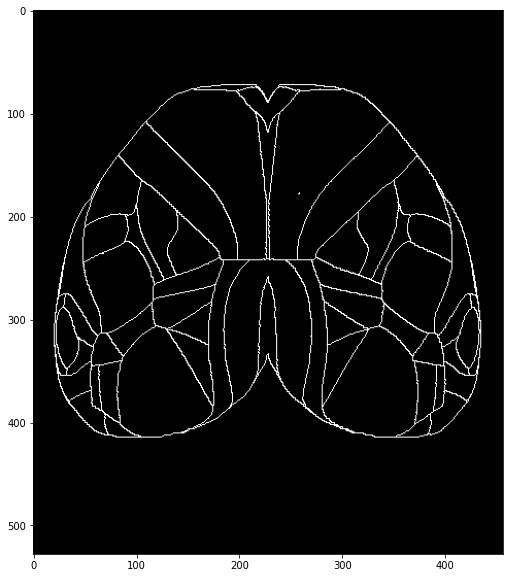

In [1]:
import numpy as np
import os
import functools
import time
from tqdm import tqdm
from allensdk.core.reference_space import ReferenceSpace
from allensdk.core.reference_space_cache import ReferenceSpaceCache
from atlas_functions import *
import ants

In [2]:
rsp, tree = open_AllenSDK()
isocortex_map, id_name_dict, bregma = map_generator(rsp, tree, structure='Isocortex')

#sma_mask = create_mask(isocortex_map, 656)
#contour = create_contour(isocortex_map)
#fig, ax = plt.subplots(figsize=(10, 10))
#plt.imshow(isocortex_map,vmax=1300, cmap='gray', alpha=0.5)
#plt.imshow(contour, cmap='binary_r')
#plt.show()



['annotation_25.nrrd']


100%|███████████████████████████████████████| 320/320 [00:00<00:00, 1752.85it/s]


In [52]:
isocortex_mask = np.zeros(isocortex_map.shape)
mask_list = []
for i in id_name_dict:
    mask_list.append(i)
isocortex_mask = create_mask(isocortex_map, mask_list)

TypeError: Invalid shape () for image data

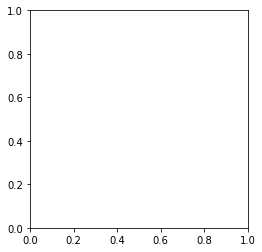

In [39]:
plt.imshow(isocortex_mask)
plt.show()